In [1]:
import IPython
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.layers import Dense,Conv2D,BatchNormalization,Dropout,UpSampling2D,ReLU,LeakyReLU,Reshape,Flatten,Activation
from keras.optimizers import Adam,RMSprop
from keras.models import Sequential,Model
import cv2
import os
import sys
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
os.listdir("../input")

['celeba-dataset', 'oneshotpokemon', 'cat-dataset', 'lego-brick-images']

In [4]:
home = "../input/celeba-dataset"

In [5]:
def is_file_in_types(file_name,file_types=[]):
    for file_type in file_types:
        if file_name.endswith(file_type):
            return True
    return False

def read_file_paths(root,file_types=[]):    
    # Remove trailing slashes.
    if root[-1] == "/" or root[-1] == "\\":
        root = root[:-1]
    files = os.listdir(root)
    #print("Root:",root,"File types:",file_types)
    #print("Root files:",files)
    paths = []
    for file in files:
        if os.path.isfile(root+"/"+file) and is_file_in_types(file_name = file, file_types=file_types) == True:
            #print("Valid file:",file)
            paths.append(root+"/"+file)
        elif os.path.isfile(root+"/"+file) == False:
            #print("Directory:",file)
            internal_paths = read_file_paths(root+"/"+file,file_types)
            #print("internal_paths:",internal_paths)
            paths = paths + internal_paths
    return paths
        


In [6]:
#  Load dataset.
file_types = ["jpg","jpeg","png"]
imageNames = read_file_paths(root = home, file_types = file_types)
imageNames = np.array(imageNames)
idx = np.random.permutation(np.arange(len(imageNames)))
imageNames = imageNames[idx]
print("Total images:",len(imageNames))

Total images: 202599


In [ ]:
# German traffic sign images.
#trainHome = "../input/gtsrb-german-traffic-sign/train"
#train_images = [trainHome+"/"+directory+"/"+img for directory in os.listdir(trainHome) for img in os.listdir(trainHome+"/"+directory)]

#testHome = "../input/gtsrb-german-traffic-sign/test"
#test_images = [testHome+"/"+img for img in os.listdir(testHome)]

#imageNames = train_images + test_images
#all_path_count = len(imageNames)
#imageNames = list(filter(lambda path: str(path).strip() != "" and str(path).strip().endswith("png"), imageNames))
#non_empty_path_count = len(imageNames)
#print("Empty paths:",all_path_count - non_empty_path_count)

#imageNames = np.array(imageNames)
#idx = np.random.permutation(np.arange(len(imageNames)))
#imageNames = imageNames[idx]
#print("Total images:",len(imageNames))


In [ ]:
# CELEB images.
#home = "../input/celeba-dataset/img_align_celeba/img_align_celeba"
#imageNames = [home+"/"+name for name in os.listdir(home)]
#imageNames = np.array(imageNames)
#idx = np.random.permutation(np.arange(len(imageNames)))
#imageNames = imageNames[idx]
#print("Total images:",len(imageNames))

In [7]:
class Util:
    def shuffle(self,lst):
        indicies = np.random.permutation(np.arange(len(lst[0])))
        result = []
        for l in lst:
            l = l[indicies]
            result.append(l)
        return tuple(l)
    
    def updateTrainable(self,model,trainable):
        for layer in model.layers:
            layer.trainable = trainable
        return model
    
    def ones(self,shape_):
        weights = np.random.uniform(low=0.99,high=1.0,size=shape_)    
        return weights

    def zeros(self,shape_):
        weights = np.random.uniform(low=0.0,high=0.01,size=shape_)
        return weights

    def noise(self,shape_):
        #noise = np.random.uniform(low=-1.0,high=1.0,size=shape_)
        noise = np.random.normal(size=shape_)
        return noise
        

In [8]:
class DataGen:
    def __init__(self,imageNames,targetShape):
        self.imageNames = imageNames
        self.targetShape = targetShape
        self.COUNTER = 0
        
    def __loadImage(self,imagePath,targetShape):
        """
        Loads single image and converts to given 'targetShape'
        """
        #print("ImagePath:",imagePath)       
        frame = cv2.imread(imagePath,cv2.IMREAD_COLOR)
        if frame is None:
            return None
        frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame,(targetShape[0],targetShape[1]))        
        return frame
    
    def __resetCounter(self):
        self.COUNTER = 0
        
    def getAll(self):
        X = []
        for imgName in tqdm(self.imageNames):
            img = self.__loadImage(imgName,self.targetShape)
            if img is not None:
                X.append(img)
        return np.array(X)
    
    def getBatch(self,batch_size):
        X = []
        curBatchImgNames = self.imageNames[self.COUNTER:self.COUNTER+batch_size]
        for imgName in tqdm(curBatchImgNames):
            img = self.__loadImage(imgName,self.targetShape)            
            self.COUNTER += 1
            if img is not None:
                X.append(img)
        # If reached last of batch then reset counter
        if len(X) < batch_size:
            self.__resetCounter()
            balance_size = batch_size - len(X)
            for i in tqdm(range(balance_size)):
                img = self.__loadImage(self.imageNames[self.COUNTER],self.targetShape)
                self.COUNTER += 1
                X.append(img)
        return np.array(X)
        

In [9]:
class GAN_Pat:
    util = Util()
    def __init__(self,dataGen,
                 lr=0.0001,
                 epochs=10,
                 batchSize=8,
                 noiseShape=(100,),
                 targetImageShape=(64,64,3),
                 imagePreProcType="TANH"):
        self.dataGen = dataGen
        self.lr = lr
        self.epochs = epochs
        self.batchSize = batchSize
        self.noiseShape = noiseShape
        self.targetImageShape = targetImageShape
        self.imagePreProcType = imagePreProcType
    
    def configModel(self):
        self.modelD = self.__discriminator(self.targetImageShape)
        self.modelD.compile(loss="binary_crossentropy",optimizer=Adam(lr=self.lr))
        
        self.modelG = self.__generator(self.noiseShape)
        self.model = Sequential()
        self.model.add(self.modelG)
        self.model.add(self.modelD)
        self.model.compile(loss="binary_crossentropy",optimizer=Adam(lr=self.lr))
        
        print("G/D param ratio:",self.modelG.count_params()/self.modelD.count_params())
        
        
    def __generator(self,noiseShape):
        model = Sequential()
        
        model.add(Dense(4*4*512,input_shape=noiseShape,use_bias=False))
        model.add(ReLU())
        model.add(Reshape((4,4,512)))
        
        model.add(UpSampling2D())
        model.add(Conv2D(512,kernel_size=3,padding="same",use_bias=False))        
        model.add(ReLU())
        model.add(BatchNormalization(momentum=0.8))
        
        model.add(UpSampling2D())
        model.add(Conv2D(512,kernel_size=3,padding="same",use_bias=False))
        model.add(ReLU())
        model.add(BatchNormalization(momentum=0.8))
        
        #model.add(UpSampling2D())
        #model.add(Conv2D(256,kernel_size=3,padding="same",use_bias=False))
        #model.add(ReLU())
        #model.add(BatchNormalization(momentum=0.8))
        
        model.add(UpSampling2D())
        model.add(Conv2D(256,kernel_size=3,padding="same",use_bias=False))
        model.add(ReLU())
        model.add(BatchNormalization(momentum=0.8))
        
        #model.add(UpSampling2D())
        #model.add(Conv2D(256,kernel_size=3,padding="same",use_bias=False))
        #model.add(ReLU())
        #model.add(BatchNormalization(momentum=0.8))
        
        model.add(UpSampling2D())
        model.add(Conv2D(256,kernel_size=3,padding="same",use_bias=False))
        model.add(ReLU())
        model.add(BatchNormalization(momentum=0.8))
                        
        #model.add(UpSampling2D())
        model.add(Conv2D(3,kernel_size=3,padding="same",use_bias=False))
        if self.imagePreProcType == "SIGMOID":
            model.add(keras.layers.Activation("sigmoid"))
        elif self.imagePreProcType == "TANH":
            model.add(Activation("tanh"))        
        model.summary()
        return model
    
    def __discriminator(self,inputShape):
        model = Sequential()
        
        model.add(Conv2D(256,kernel_size=3,strides=2,padding="same",input_shape=inputShape,use_bias=False))
        model.add(LeakyReLU(0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(256,kernel_size=3,strides=2,padding="same",use_bias=False))
        model.add(LeakyReLU(0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(256,kernel_size=3,strides=2,padding="same",use_bias=False))
        model.add(LeakyReLU(0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(256,kernel_size=3,strides=1,padding="same",use_bias=False))
        model.add(LeakyReLU(0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dropout(0.25))
        
        #model.add(Conv2D(256,kernel_size=3,strides=2,padding="same",use_bias=False))
        #model.add(LeakyReLU(0.2))
        #model.add(BatchNormalization(momentum=0.8))
        #model.add(Dropout(0.25))  
                
        model.add(Flatten())
        
        model.add(Dense(1,use_bias=False))
        model.add(Activation("sigmoid"))
        
        model.summary()
        return model
        
    def train(self,epochs=None,batch_size=None,X_train=None):
        #self.__configModel()
        if epochs is not None:
          self.epochs = epochs
        if batch_size is not None:
          self.batchSize = batch_size
        #Y_ones = self.util.ones((self.batchSize))
        #Y_zeros = self.util.zeros((self.batchSize))
        num_examples = 0
        if X_train is not None:
            num_examples = len(X_train)
        else:
            num_examples = len(self.dataGen.imageNames)
        num_iters = int(num_examples/self.batchSize)
        hist={
            "loss_G":[],
            "loss_D":[]
        }
        for epoch in range(self.epochs):
            for i_iter in range(num_iters):
                Y_ones = self.util.ones((self.batchSize))
                Y_zeros = self.util.zeros((self.batchSize))
                # If X_train is given then use those images else load images from data generator.
                if X_train is None:
                  imgs_real = self.dataGen.getBatch(self.batchSize)
                else:
                  #idx = np.random.permutation(np.arange(len(X_train)))[:self.batchSize]
                  imgs_real = X_train[(i_iter * self.batchSize) : (i_iter + 1)*self.batchSize]
                # Preprocess images as per range specified.
                if self.imagePreProcType == "SIGMOID":
                    imgs_real = imgs_real / 255.0
                elif self.imagePreProcType == "TANH":
                    imgs_real = imgs_real/127.5 - 1.

                noise = self.util.noise((self.batchSize,self.noiseShape[0]))
                imgs_fake = self.modelG.predict(noise)

                # Train discriminator.
                self.modelD = self.util.updateTrainable(self.modelD,True)
                loss_D_fake = self.modelD.train_on_batch(imgs_fake,Y_ones) # Generated imgs are 1.
                loss_D_real = self.modelD.train_on_batch(imgs_real,Y_zeros) # Real images are zeros.
                loss_D = (loss_D_fake + loss_D_real) * 0.5
                self.modelD = self.util.updateTrainable(self.modelD,False)

                # Train generator.
                Y_noise = np.concatenate((Y_ones[:int(self.batchSize/2)],Y_zeros[:int(self.batchSize/2)]))
                loss_G = self.model.train_on_batch(noise,Y_noise)
                #loss_G = self.model.train_on_batch(noise,Y_ones)
                print("{}/{} Epoch {}/{} loss_D:{} \tloss_G:{}".format(i_iter+1, num_iters,epoch+1,self.epochs,loss_D,loss_G))

                #hist["loss_G"].append(loss_G)
                #hist["loss_D"].append(loss_D)
                if i_iter % 50 ==0:
                    hist["loss_G"].append(loss_G)
                    hist["loss_D"].append(loss_D)
                    IPython.display.clear_output(wait=True)
                    num_test = 10
                    #X_test = np.random.normal(0, 1, (num_test, self.noiseShape[0]))
                    #imgs_G = self.modelG.predict(X_test)
                    imgs_G = imgs_fake[:num_test]
                    if self.imagePreProcType == "SIGMOID":
                        imgs_G = imgs_G * 255.0
                    elif self.imagePreProcType == "TANH":
                        imgs_G = (imgs_G+1.0)*127.5
                    imgs_G = imgs_G.astype(np.uint8)
                    fig = plt.figure(figsize=(15,5))
                    for i in range(len(imgs_G)):
                        plt.subplot(1,num_test,i+1)
                        plt.imshow(imgs_G[i])
                    plt.show()

                    plt.plot(hist["loss_D"],label="loss_D")
                    plt.plot(hist["loss_G"],label="loss_G")
                    plt.legend(loc="upper left")
                    plt.title("Losses: {}/{} Epoch {}/{}".format(i_iter+1, num_iters,epoch+1,self.epochs))
                    plt.show()
                

In [11]:
# load all data.
targetShape = (64,64,3)
num_images = 10000 #len(imageNames)

idx = np.random.permutation(np.arange(len(imageNames)))[:num_images]
train_img_names = np.array(imageNames)[idx]
dataGenTrain = DataGen(train_img_names,targetShape)

#X_train = dataGenTrain.getBatch(num_images)
X_train = dataGenTrain.getAll()
print("X_train:",X_train.shape)


 54%|█████▍    | 5397/10000 [00:14<00:12, 374.86it/s]


100%|██████████| 10000/10000 [00:27<00:00, 360.28it/s]

X_train: (10000, 64, 64, 3)


In [ ]:
print(imageNames[0])

In [ ]:

path = "../input/lego-brick-images/lego brick images/LEGO brick images/train/2357 Brick corner 1x2x2/201706171206-0317.png"
frame = cv2.imread(path,cv2.IMREAD_COLOR)
print(frame.shape)
plt.imshow(frame)
plt.show()

X_print: (10, 64, 64, 3)


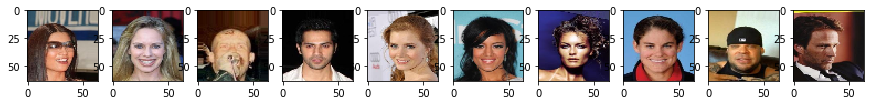

In [12]:
# Print random images.
num_print = 10
idx_print = np.random.permutation(np.arange(len(X_train)))[:num_print]
X_print = X_train[idx_print]
print("X_print:",X_print.shape)
fig = plt.figure(figsize=(15,5))
for i in range(num_print):
    plt.subplot(1,num_print,i+1)
    plt.imshow(X_print[i])
plt.show()

In [13]:
targetShape = (64,64,3)
#util = Util()
dataGen = DataGen(imageNames = imageNames,
                 targetShape = targetShape)
trainer = GAN_Pat(dataGen = dataGen,
                  lr = 0.00005,
                 noiseShape = (100,), 
                 targetImageShape=targetShape,
                 imagePreProcType = "SIGMOID")
trainer.configModel()



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 256)       6912      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 256)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       589824    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
batch_normalization_1

### Target Shape (32,32,3):
<pre>
<h3> Small model with layers [32,64,128,256]: </h3>
<b>1. Small model, high lr, small batch:</b>
    <b>a. Loss:</b> Both losses become equal to zero very soon (by 5000 epochs).    
    <b>b. Output:</b> Generated images are extremely blurred.
<b>2. Small model, high lr, large batch:</b>    
    <b>a. Loss:</b> Both losses become equal to zero very soon (by 5000 epochs).    
    <b>b. Output:</b> Generated images are extremely blurred.
<b>3. Small model, low lr, small batch:</b>
    <b>a. Loss:</b> Both losses remain constant and model seems to be learning.
    <b>b. Output:</b> After epoch 4 images could be recognized. Clear face attributes visible like eyes, nose, hair etc. But not of very good quality. You could recognize that face exists but identity of face could not be recognized.
<b>4. Small model, low lr. large batch:</b>
    <b>a. Loss:</b> 
    <b>b. Output:</b> 
    
<h3> Large model with layers  [64,128,256,512,1024]: </h3>
<b>5. Big model, high lr, small batch:</b>
    <b>a. Loss:</b> 
    <b>b. Output:</b> 
<b>6. Big model, high lr. large batch:</b>
    <b>a. Loss:</b>
    <b>b. Output:</b> 
<b>7. Big model, low lr, small batch:</b>
    <b>a. Loss:</b> 
    <b>b. Output:</b> 
<b>8. Big model, low lr. large batch:</b>
    <b>a. Loss:</b> 
    <b>b. Output:</b> 
</pre>

In [14]:
# Take a subset of training examples.

idx = np.random.permutation(np.arange(len(X_train)))
X_run = X_train[idx] #[:10000]

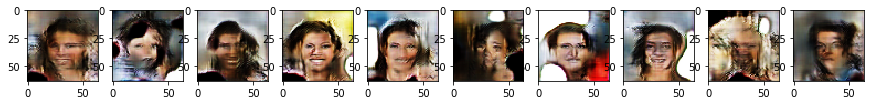

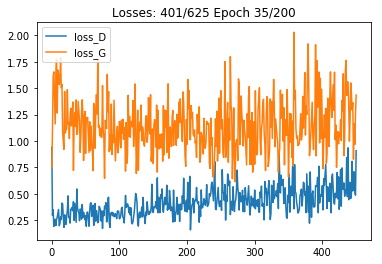

402/625 Epoch 35/200 loss_D:0.5014325976371765 	loss_G:1.098882794380188
403/625 Epoch 35/200 loss_D:0.6419112086296082 	loss_G:2.0177478790283203
404/625 Epoch 35/200 loss_D:0.35971972346305847 	loss_G:1.9901747703552246
405/625 Epoch 35/200 loss_D:0.39666980504989624 	loss_G:1.1084039211273193
406/625 Epoch 35/200 loss_D:0.49678903818130493 	loss_G:1.7767072916030884
407/625 Epoch 35/200 loss_D:0.39229750633239746 	loss_G:1.1929962635040283
408/625 Epoch 35/200 loss_D:0.3441035747528076 	loss_G:1.3292982578277588
409/625 Epoch 35/200 loss_D:0.6003384590148926 	loss_G:1.2075797319412231
410/625 Epoch 35/200 loss_D:0.7594542503356934 	loss_G:1.2044848203659058
411/625 Epoch 35/200 loss_D:0.5570574998855591 	loss_G:1.4127377271652222
412/625 Epoch 35/200 loss_D:0.7141436338424683 	loss_G:1.4826974868774414
413/625 Epoch 35/200 loss_D:0.37833714485168457 	loss_G:1.2618976831436157
414/625 Epoch 35/200 loss_D:0.6031284332275391 	loss_G:0.8515782356262207
415/625 Epoch 35/200 loss_D:0.4803

In [ ]:
trainer.train(epochs=200,
                       batch_size=16,
                       X_train = X_run)